# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Nov 19 06:19:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        
        x = self.load_sample(self.files[index])
        x = x.resize((RESCALE_SIZE, RESCALE_SIZE))
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        if self.mode == 'train':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            transform = transforms.Compose([
                transforms.RandomResizedCrop(244),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            return transform(x), label_id.item()
        elif self.mode == 'val':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            return transform(x), label_id.item()
        else:
            return transform(x)
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from pathlib import Path
TRAIN_DIR = Path('../input/journeyspringfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journeyspringfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
import os

augmentated_train_files = []
for file in train_files:
    image = Image.open(file)
    image.load()
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    
    flipped_tr = transforms.RandomHorizontalFlip(1)
    grayscale_tr = transforms.Grayscale(3)
    color_jitter_tr = transforms.ColorJitter(brightness=.5, hue=.3)
    
    flipped_im = flipped_tr(image)
    grayscale_im = grayscale_tr(image)
    color_jitter_im = color_jitter_tr(image)
    
    new_dir = '/kaggle/working/' + str(file.parent)[9:]
    name = str(file.name)[:-4]
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    
    flipped_im.save(f'{new_dir}/{name}flipped.jpg')
    grayscale_im.save(f'{new_dir}/{name}grayscale.jpg')
    color_jitter_im.save(f'{new_dir}/{name}color_jitter.jpg')
    
    augmentated_train_files.append(Path(f'{new_dir}/{name}flipped.jpg'))
    augmentated_train_files.append(Path(f'{new_dir}/{name}grayscale.jpg'))
    augmentated_train_files.append(Path(f'{new_dir}/{name}color_jitter.jpg'))
    
train_files = train_files + augmentated_train_files

In [ ]:
len(train_files)

62796

In [ ]:
len(val_files)

5234

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

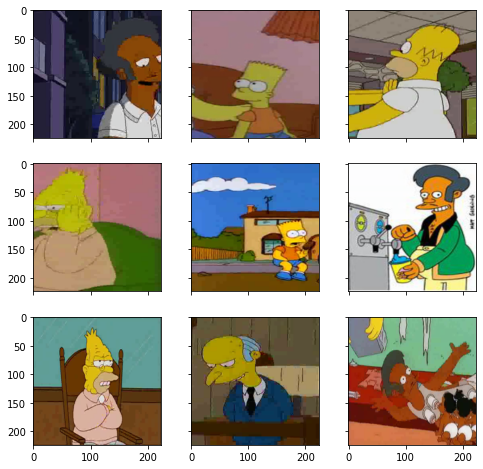

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

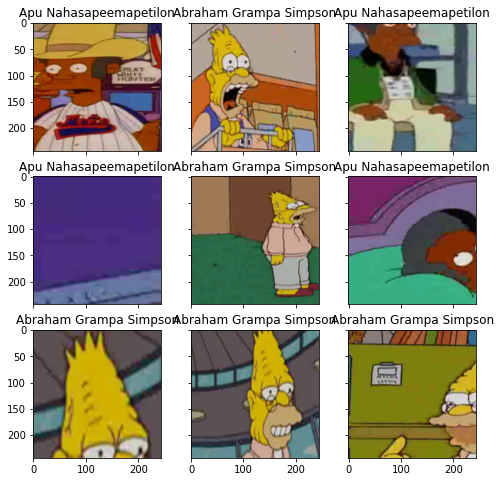

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети






In [ ]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout2d(p=0.2, inplace=False)
    (2): ReLU()
    (3): BatchNorm2d(1

Запустим обучение сети.

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=20, batch_size=512)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 3.1081480414208746


epoch:   5%|▌         | 1/20 [08:03<2:33:10, 483.68s/it]


Epoch 001 train_loss: 3.1081     val_loss 2.1609 train_acc 0.1744 val_acc 0.4272
loss 2.471553628782883


epoch:  10%|█         | 2/20 [15:51<2:22:14, 474.12s/it]


Epoch 002 train_loss: 2.4716     val_loss 1.6434 train_acc 0.3195 val_acc 0.5657
loss 2.1937518973161905


epoch:  15%|█▌        | 3/20 [23:35<2:13:03, 469.59s/it]


Epoch 003 train_loss: 2.1938     val_loss 1.3131 train_acc 0.3995 val_acc 0.6435
loss 2.014726312777534


epoch:  20%|██        | 4/20 [31:16<2:04:19, 466.22s/it]


Epoch 004 train_loss: 2.0147     val_loss 1.1539 train_acc 0.4486 val_acc 0.6916
loss 1.868344150050308


epoch:  25%|██▌       | 5/20 [38:58<1:56:12, 464.81s/it]


Epoch 005 train_loss: 1.8683     val_loss 1.0660 train_acc 0.4897 val_acc 0.7042
loss 1.7448935035960949


epoch:  30%|███       | 6/20 [46:43<1:48:29, 464.97s/it]


Epoch 006 train_loss: 1.7449     val_loss 0.9134 train_acc 0.5221 val_acc 0.7616
loss 1.6672127768905143


epoch:  35%|███▌      | 7/20 [54:30<1:40:52, 465.55s/it]


Epoch 007 train_loss: 1.6672     val_loss 0.8646 train_acc 0.5442 val_acc 0.7673
loss 1.5928863120675885


epoch:  40%|████      | 8/20 [1:02:11<1:32:48, 464.07s/it]


Epoch 008 train_loss: 1.5929     val_loss 0.8668 train_acc 0.5643 val_acc 0.7742
loss 1.519822759236171


epoch:  45%|████▌     | 9/20 [1:09:52<1:24:53, 463.04s/it]


Epoch 009 train_loss: 1.5198     val_loss 0.8200 train_acc 0.5854 val_acc 0.7816
loss 1.470916204615318


epoch:  50%|█████     | 10/20 [1:17:32<1:17:00, 462.08s/it]


Epoch 010 train_loss: 1.4709     val_loss 0.7690 train_acc 0.5980 val_acc 0.7988
loss 1.4280832063408366


epoch:  55%|█████▌    | 11/20 [1:25:13<1:09:15, 461.68s/it]


Epoch 011 train_loss: 1.4281     val_loss 0.7539 train_acc 0.6095 val_acc 0.8015
loss 1.393079311743353


epoch:  60%|██████    | 12/20 [1:32:56<1:01:37, 462.21s/it]


Epoch 012 train_loss: 1.3931     val_loss 0.7681 train_acc 0.6193 val_acc 0.7979
loss 1.358817889163567


epoch:  65%|██████▌   | 13/20 [1:40:40<53:59, 462.85s/it]  


Epoch 013 train_loss: 1.3588     val_loss 0.7094 train_acc 0.6289 val_acc 0.8137
loss 1.3170407738941659


epoch:  70%|███████   | 14/20 [1:48:51<47:07, 471.20s/it]


Epoch 014 train_loss: 1.3170     val_loss 0.7045 train_acc 0.6391 val_acc 0.8164
loss 1.2970779660219023


epoch:  75%|███████▌  | 15/20 [1:57:15<40:05, 481.14s/it]


Epoch 015 train_loss: 1.2971     val_loss 0.6980 train_acc 0.6461 val_acc 0.8183
loss 1.2580337314759404


epoch:  80%|████████  | 16/20 [2:05:30<32:21, 485.40s/it]


Epoch 016 train_loss: 1.2580     val_loss 0.6665 train_acc 0.6544 val_acc 0.8267
loss 1.2475845846706717


epoch:  85%|████████▌ | 17/20 [2:13:42<24:22, 487.38s/it]


Epoch 017 train_loss: 1.2476     val_loss 0.6580 train_acc 0.6613 val_acc 0.8349
loss 1.2105873899859556


epoch:  90%|█████████ | 18/20 [2:21:56<16:18, 489.34s/it]


Epoch 018 train_loss: 1.2106     val_loss 0.5980 train_acc 0.6707 val_acc 0.8475
loss 1.1922608733260713


epoch:  95%|█████████▌| 19/20 [2:29:59<08:07, 487.48s/it]


Epoch 019 train_loss: 1.1923     val_loss 0.6146 train_acc 0.6738 val_acc 0.8449
loss 1.1803761980428658


epoch: 100%|██████████| 20/20 [2:38:00<00:00, 474.05s/it]


Epoch 020 train_loss: 1.1804     val_loss 0.5792 train_acc 0.6777 val_acc 0.8504


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=512)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.186861057457358


epoch:  10%|█         | 1/10 [08:17<1:14:39, 497.74s/it]


Epoch 001 train_loss: 1.1869     val_loss 0.5709 train_acc 0.6749 val_acc 0.8542
loss 1.1485739687960865


epoch:  20%|██        | 2/10 [16:22<1:05:22, 490.28s/it]


Epoch 002 train_loss: 1.1486     val_loss 0.6279 train_acc 0.6859 val_acc 0.8449
loss 1.1404711664372231


epoch:  30%|███       | 3/10 [24:22<56:37, 485.38s/it]  


Epoch 003 train_loss: 1.1405     val_loss 0.5770 train_acc 0.6900 val_acc 0.8456
loss 1.1292228442604006


epoch:  40%|████      | 4/10 [32:21<48:17, 482.86s/it]


Epoch 004 train_loss: 1.1292     val_loss 0.5772 train_acc 0.6924 val_acc 0.8529
loss 1.1100606885531334


epoch:  50%|█████     | 5/10 [40:19<40:06, 481.33s/it]


Epoch 005 train_loss: 1.1101     val_loss 0.5414 train_acc 0.6993 val_acc 0.8622
loss 1.097614208758504


epoch:  60%|██████    | 6/10 [48:19<32:02, 480.65s/it]


Epoch 006 train_loss: 1.0976     val_loss 0.5637 train_acc 0.7010 val_acc 0.8598
loss 1.0749055290838754


epoch:  70%|███████   | 7/10 [56:18<24:00, 480.26s/it]


Epoch 007 train_loss: 1.0749     val_loss 0.5349 train_acc 0.7053 val_acc 0.8580
loss 1.0670232936617476


epoch:  80%|████████  | 8/10 [1:04:23<16:03, 481.68s/it]


Epoch 008 train_loss: 1.0670     val_loss 0.5639 train_acc 0.7073 val_acc 0.8594
loss 1.0555696675592003


epoch:  90%|█████████ | 9/10 [1:12:22<08:00, 480.74s/it]


Epoch 009 train_loss: 1.0556     val_loss 0.5479 train_acc 0.7129 val_acc 0.8653
loss 1.039196383710864


epoch: 100%|██████████| 10/10 [1:20:21<00:00, 482.19s/it]


Epoch 010 train_loss: 1.0392     val_loss 0.5470 train_acc 0.7153 val_acc 0.8630


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

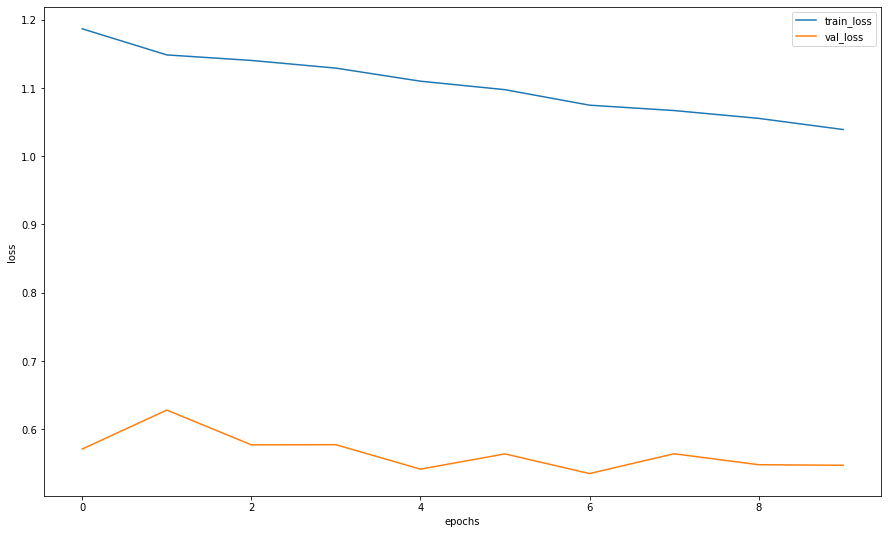

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=512)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0511741965156778


epoch:  10%|█         | 1/10 [08:16<1:14:26, 496.23s/it]


Epoch 001 train_loss: 1.0512     val_loss 0.5839 train_acc 0.7125 val_acc 0.8556
loss 1.029112040415654


epoch:  20%|██        | 2/10 [16:17<1:04:58, 487.32s/it]


Epoch 002 train_loss: 1.0291     val_loss 0.5297 train_acc 0.7185 val_acc 0.8684
loss 1.0233531302043197


epoch:  30%|███       | 3/10 [24:25<56:53, 487.63s/it]  


Epoch 003 train_loss: 1.0234     val_loss 0.5177 train_acc 0.7222 val_acc 0.8693
loss 1.0183623286901564


epoch:  40%|████      | 4/10 [32:31<48:42, 487.08s/it]


Epoch 004 train_loss: 1.0184     val_loss 0.5121 train_acc 0.7219 val_acc 0.8735
loss 1.0108154214896308


epoch:  50%|█████     | 5/10 [40:38<40:35, 487.17s/it]


Epoch 005 train_loss: 1.0108     val_loss 0.5289 train_acc 0.7239 val_acc 0.8661
loss 0.9911126751711098


epoch:  60%|██████    | 6/10 [48:41<32:21, 485.49s/it]


Epoch 006 train_loss: 0.9911     val_loss 0.5052 train_acc 0.7284 val_acc 0.8722
loss 0.9793767550848299


epoch:  70%|███████   | 7/10 [56:43<24:13, 484.35s/it]


Epoch 007 train_loss: 0.9794     val_loss 0.5356 train_acc 0.7307 val_acc 0.8718
loss 0.971457475332312


epoch:  80%|████████  | 8/10 [1:04:45<16:07, 483.69s/it]


Epoch 008 train_loss: 0.9715     val_loss 0.5166 train_acc 0.7331 val_acc 0.8666
loss 0.9690398517380293


epoch:  90%|█████████ | 9/10 [1:12:46<08:02, 482.90s/it]


Epoch 009 train_loss: 0.9690     val_loss 0.5369 train_acc 0.7358 val_acc 0.8676
loss 0.971506232121574


epoch: 100%|██████████| 10/10 [1:20:50<00:00, 485.01s/it]


Epoch 010 train_loss: 0.9715     val_loss 0.5074 train_acc 0.7349 val_acc 0.8773


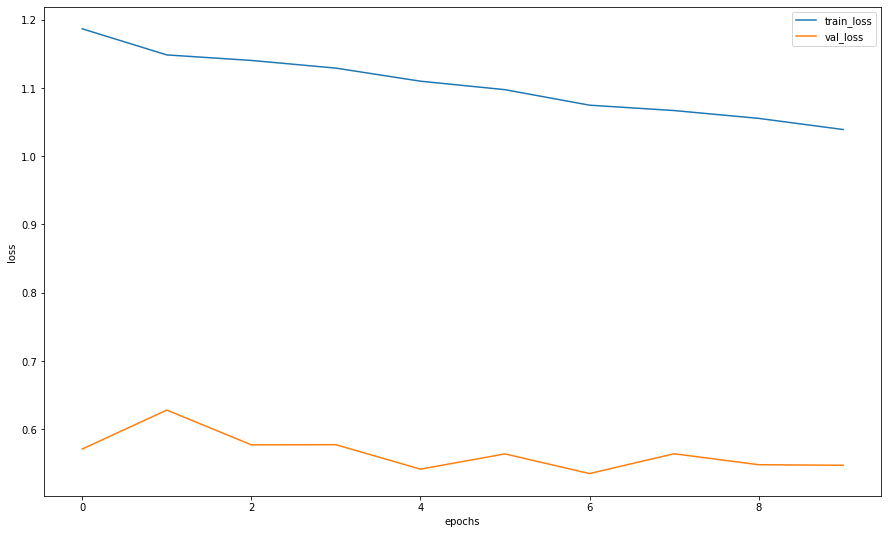

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Проверка качества

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, list(y_pred), average=None)


array([0.83333333, 1.        , 1.        , 1.        , 1.        ,
       0.        ])

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

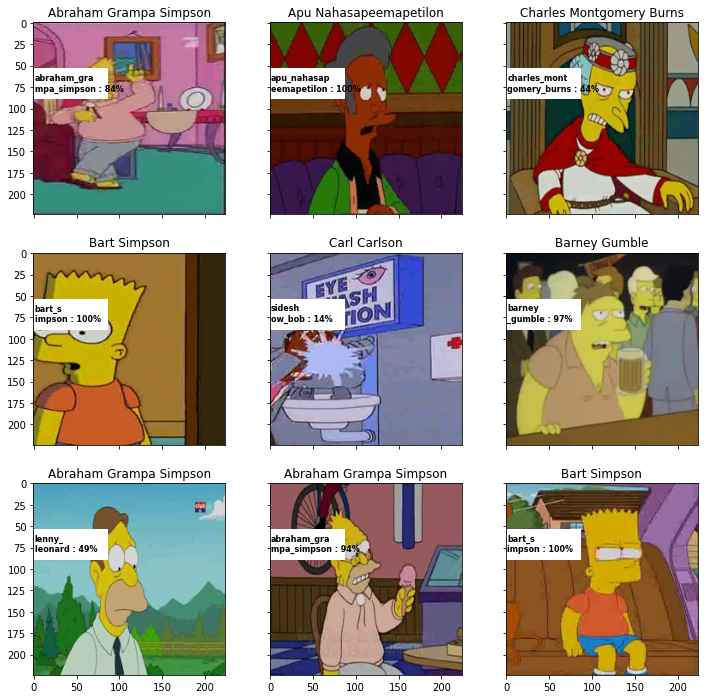

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=512)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/kaggle/working/submission.csv', index=False)